# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import math
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cls -- числовой номер класса

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0,)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0,)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

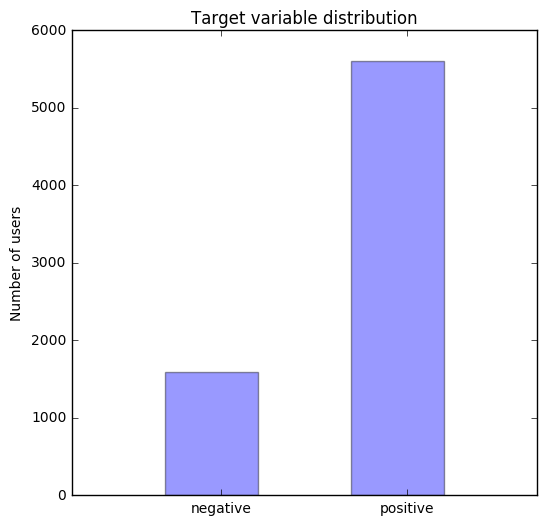

In [4]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [5]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)
p=api.UsersLookup([713195014226969000,2881534905,202388889])
print p[0]

{"created_at": "Wed Oct 13 23:08:21 +0000 2010", "description": "Author- Artist-Marvel-Cars-Books-Music", "favourites_count": 21456, "followers_count": 1053, "friends_count": 1968, "geo_enabled": true, "id": 202388889, "lang": "en", "listed_count": 26, "location": "Gulfport, FL", "name": "Kim Salter", "profile_background_color": "EDECE9", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/164141622/2010_cobra_fuck_me_running.jpg", "profile_banner_url": "https://pbs.twimg.com/profile_banners/202388889/1475429553", "profile_image_url": "http://pbs.twimg.com/profile_images/767858385463246849/2Kj4occh_normal.jpg", "profile_link_color": "4A913C", "profile_sidebar_fill_color": "E3E2DE", "profile_text_color": "634047", "screen_name": "mustangkim11", "status": {"created_at": "Sun Oct 02 22:07:58 +0000 2016", "hashtags": [], "id": 782703700418654208, "id_str": "782703700418654208", "lang": "en", "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web 

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [6]:
GEO_USER_NAME = ""

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string
    """
    url = "http://api.geonames.org/searchJSON?q=%s&maxRows=10&username=%s" %(location, GEO_USER_NAME)
    r = requests.get(url)
    data = json.loads(r.text)
    if ('geonames' in data and data['geonames'] and 'countryName' in data['geonames'][0] and 'lat' in data['geonames'][0] and 'lng' in data['geonames'][0]):
        result = (float(data['geonames'][0]['lat']),float(data['geonames'][0]['lng']),data['geonames'][0]['countryName'])
        return result
    else:
        result = (None,None,None)
        return result

In [7]:
record={}
record["lat"], record["lon"], record["country"]=get_coordinates_by_location('6ix')
print record

{'lat': None, 'country': None, 'lon': None}


Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [8]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
print len(processed_users)   
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record
  
def get_user_records(df):
    print len(df)
    data_records = []
    n = 100
    blocks = [df[i:i + n] for i in xrange(0, len(df), n)]
    for block in blocks:
        try:
            users = api.UsersLookup(block)
            for user in users:
                record = twitter_user_to_dataframe_record(user)
                json.dump(record, f)
                f.write('\n')
                data_records.append(record)
        except:
            print 'ERROR in TwitterApi'
            print 'Users id:', block
            break
    return data_records

user_records += get_user_records(filter(lambda us: us not in processed_users, df_users["uid"]))
f.close()

    # your code here
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    #pass

# Maximum number of user IDs returned by Twitter's user lookup



print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"


0
11947


C:\Users\user\Anaconda2\lib\site-packages\dateutil\parser.py:601: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif res.tzname and res.tzname in time.tzname:


Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


In [9]:
print df_full.head()

          uid  cls               name    screen_name  \
0   202388889  1.0         Kim Salter   mustangkim11   
1  1392518336  0.0       Tomboy Tarts    TomboyTarts   
2   361208576  1.0      THE MANC GEEK       BigA85GL   
3  1535215357  1.0            L 🎃 🍂    laurynjiles   
4  4396196375  1.0  #1stEdifyToUplift  EdifyToUplift   

                                         description verified  \
0             Author- Artist-Marvel-Cars-Books-Music    False   
1  Celebrating the classic tomboy spirit with a b...    False   
2  Mancunian geek, blogger/writer/reviewer. Consu...    False   
3  I'll be waiting here for you on this New York ...    False   
4  Awareness.Advocacy.Ascend🎈• Building awarenes...    False   

                  location       lat        lon         country created_at  \
0             Gulfport, FL  27.74836  -82.70343   United States    2010-10   
1      Singapore/Malaysia    1.54860  103.52690        Malaysia    2013-04   
2           Manchester, UK  53.48095   -2

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

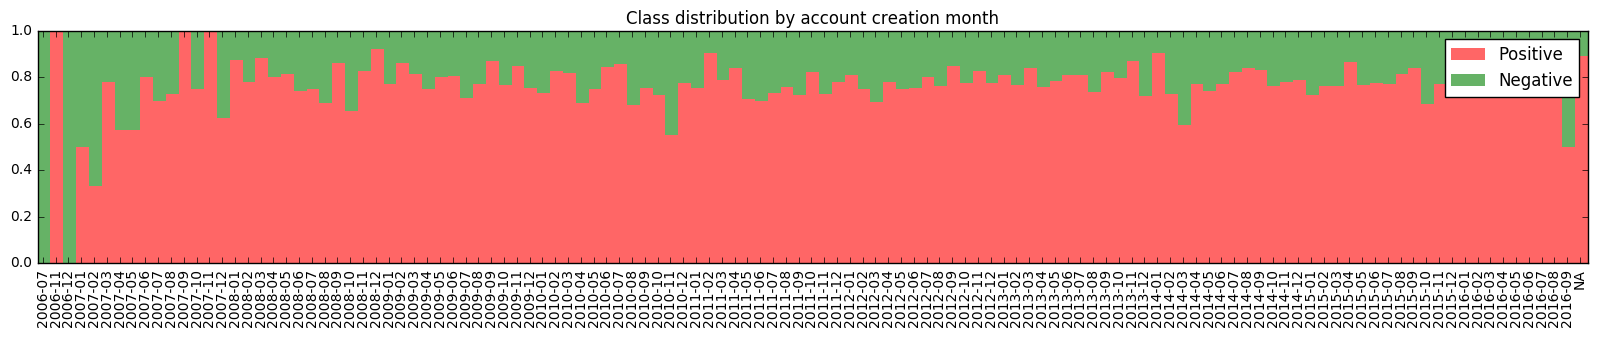

In [10]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos = np.zeros(len(grouped))
    count_neg = np.zeros(len(grouped))
    # your code here 
    for i, (date, group) in enumerate(grouped):
        count_pos[i] =  len(group[group['cls'] == 1])
        count_neg[i] =  len(group[group['cls'] == 0])
        dts.append(date)
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

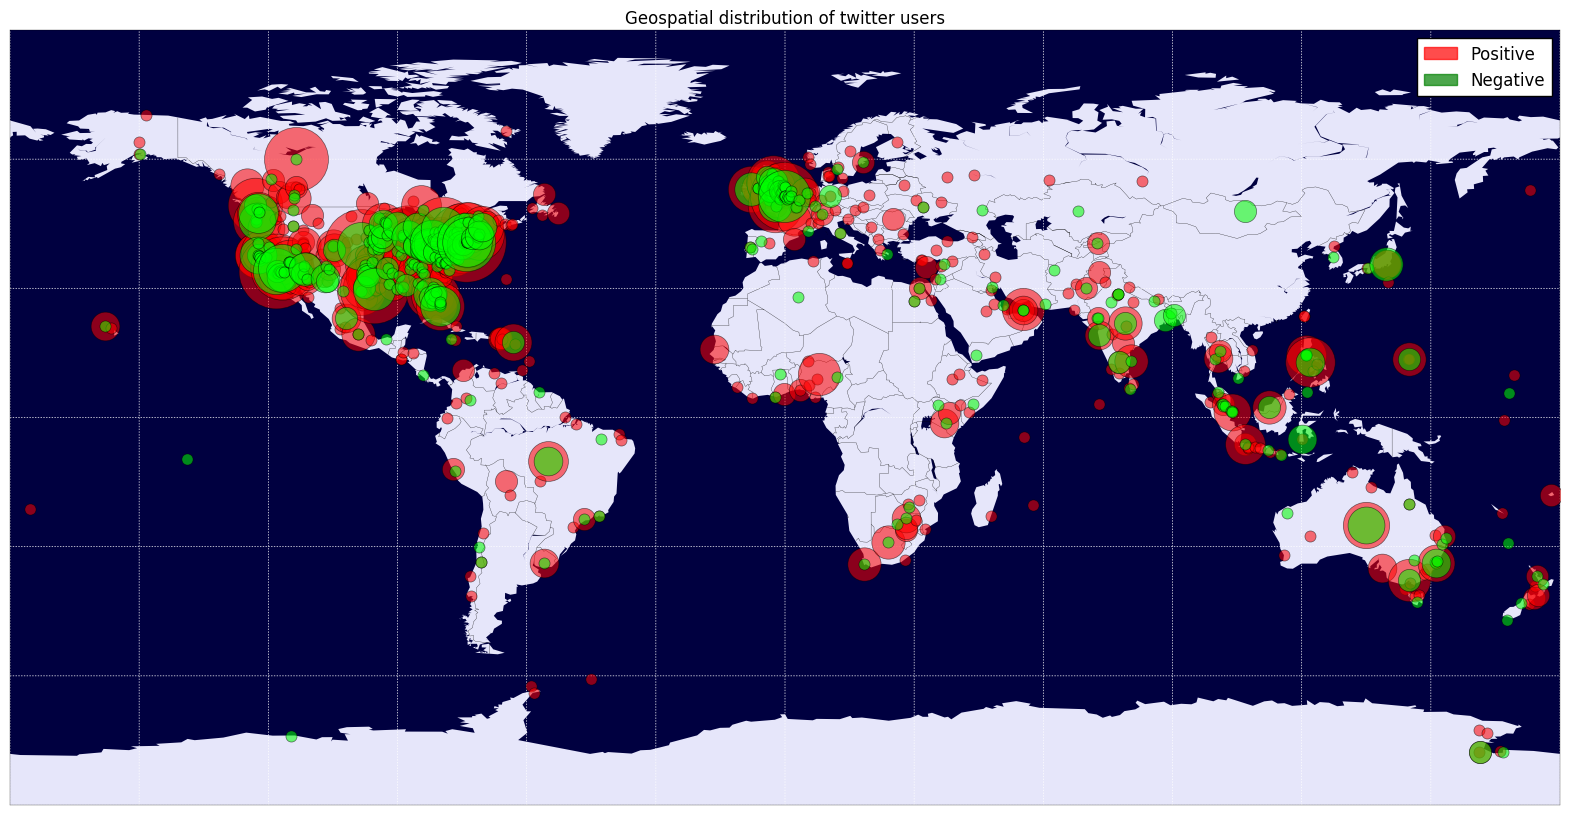

In [11]:
from matplotlib.patches import Patch as ptch

pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def points_in_one_location(df, s):
    location_list = list()
    df_grouped = df.groupby(['lon', 'lat'])
    for x, group in df_grouped:
        location_list.append((x[0], x[1], (s[0], s[1], s[2]),8*log2(2*len(group)) ))
    return location_list

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    # your code here
    df_clean = df_full[pd.notnull(df_full["lon"]) & pd.notnull(df_full["lat"])]
    location_list = points_in_one_location(df_clean[df_clean["cls"] == 1], (1,0,0))
    location_list += points_in_one_location(df_clean[df_clean["cls"] == 0], (0,1,0))
    for loc in location_list:
        pl.plot(loc[0], loc[1], color=loc[2], linestyle='none', marker='o', markersize=loc[3], alpha=0.55)
    return

plot_points_on_map(df_full)
pl.title("Geospatial distribution of twitter users")
red_patch = ptch(color='red', alpha=0.7, label='Positive')
green_patch = ptch(color='green', alpha=0.7, label='Negative')
pl.legend(handles=[red_patch, green_patch])
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Размер кружка на карте определяет количество пользователей в одной локации (использовался логарифмический масштаб)
* Была изменена прозрачность точек для более наглядного обозревания участков с высокой плотностью пользователей


#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

            median   mean    max
Negative:   332      2153    232079
Positive:   326      1929    172322


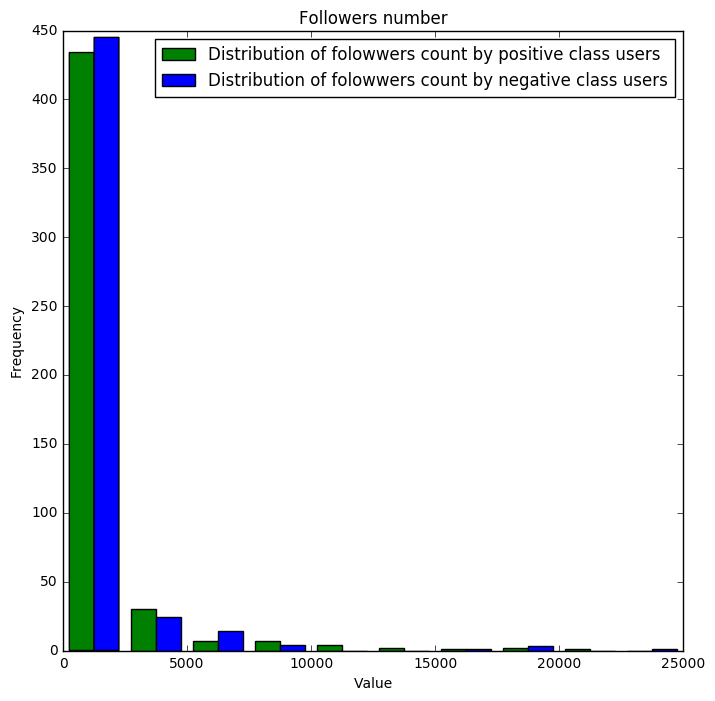

In [12]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    print '            median   mean    max'
    print 'Negative:   %d      %d    %d' % (users_wth_neg_class["followers_count"].median(),
                                    users_wth_neg_class["followers_count"].mean(),
                                    users_wth_neg_class["followers_count"].max())
    print 'Positive:   %d      %d    %d' % (users_wth_pos_class["followers_count"].median(),
                                    users_wth_pos_class["followers_count"].mean(),
                                    users_wth_pos_class["followers_count"].max())
    pl.figure(figsize=(8,8))
    pl.hist([users_wth_pos_class["followers_count"],users_wth_neg_class["followers_count"]],fill=True,range=(0,25000),color=['green','blue'], 
              label=['Distribution of folowwers count by positive class users','Distribution of folowwers count by negative class users'])
    pl.xlabel('Value')
    pl.ylabel('Frequency')
    pl.title('Followers number')
    pl.legend(loc='upper right')
    pl.show()
    return
descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

Медиана и среднее значение различаются, так как значения более популярных людей (которых не так и много в произвольной выборке) оказывает большое внимание на среднее значение. Тогда, судя по медианам разных групп пользователей, популярность "одинакова".


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [13]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1053.0,1968.0,9492.0,21456.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1205.0,841.0,19356.0,7196.0,114.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,635.0,577.0,7854.0,1141.0,28.0
3,1535215357,1.0,L 🎃 🍂,laurynjiles,I'll be waiting here for you on this New York ...,False,Marvel. DC.,NaN,NaN,None,2013-06,2373.0,2434.0,188078.0,88580.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈• Building awarenes...,False,God is my refuge; gem❤️,NaN,NaN,None,2015-12,1251.0,993.0,37601.0,27548.0,77.0
